### Workflow:

1. Set initial variables and load 1 dataset for the stoichiometry
2. Select initial hyperparameters and train, select best model.
3. Load other data for same stoichiometry, transfer model and train
4. Select best model for each velocity
5. Extract data and build linear graphic

In [1]:
#Hide warnings when logging
from tensorflow.compat.v1.logging import set_verbosity,ERROR
set_verbosity(ERROR) 

from Utils import *

Using TensorFlow backend.


## 1. Create variables and load dataset

In [2]:
directory = 'models/La0.5/' 
stoichiom = ['La0.5']      #Which stoichiometry is to be used on this run?
name='data/La0.5Ca0.5NiO310C.txt'  #First data set to load.

#Create new directory if it doesn't exist
import os
OUTPUT_DIRECTORY = directory
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    print('Directory created')
    
#Dom has to be selected so as to get most important data for the given experiment
domData = (210,600)
df,NormPrms = LoadDF(name,dom=domData) 

## 2. Select initial hyperparameters and train.

### Set this array according to the description of its entries.
##### Each column corresponds to one of the logistic functions
Row1: Set S values: Suggested S values (normalized T)

Row2: "Degrees of freedom" for this S value (how much can it deviate from suggested S)

Row3: Orientation of curve. If 1, gain event. If 0, loss event

Row4: Suggested k values (steepness of curve)

Row5: Suggested A values (relative importance of event, by how much did mass increment with this event?)

Row6: Which S values are to be fixed

<IPython.core.display.Javascript object>


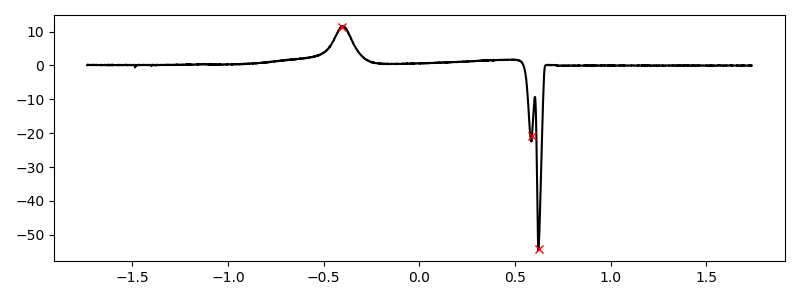

In [3]:
def smooth(y, box_pts=30):
    box = ones(box_pts)/box_pts
    y_smooth = convolve(y, box, mode='same')
    return y_smooth
deriv = diff(df.y)/diff(df.x)
deriv = smooth(deriv,3)


%matplotlib notebook
pts = GetPoints(df.x.iloc[:-1],deriv)

In [4]:
%matplotlib inline
pts    

[-0.405272409703483, 0.587644383602242, 0.6242255286187688]

In [18]:
hyper = array([[-0.55,-0.40,0.36,0.577,0.62,0.62],        #Suggested 's' values
               [0.3,0.3,0.3,0.3,0.3,0.03],            #Max. deviation of the s values.
               [1,1,1,0,0,1],                            #Orientation of the given curve
               [-6.07,-27.93,-6.93,65.97,65.00,50.34],   #k vals
               [1.04,1.32,0.94,0.88,1.9,-1.09],         #A vals 
               [0,0,0,1,1,0]])                           #freezeS

where = directory+'INITIAL_W{}.hdf5'
print(f"Models will be stored at {where}\n")

Models will be stored at models/La0.5/INITIAL_W{}.hdf5



Training model 0...
Epoch 00099: early stopping


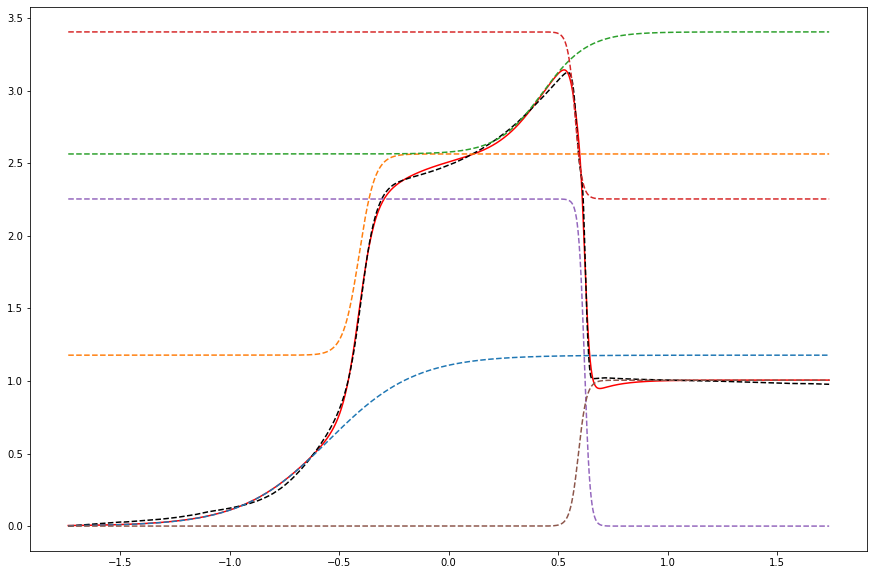

Cost = 0.0006929302295191683
Training model 1...


############
Model has failed to converge!                  
Restart optimization                  
Try lowering lr.                  
#############



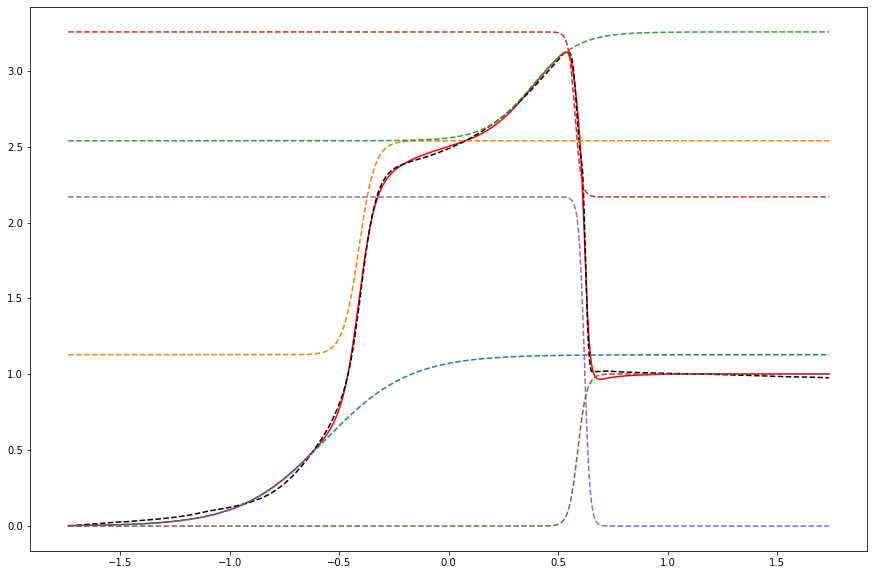

Cost = 0.0005959226504741841
Training model 2...
Epoch 00092: early stopping


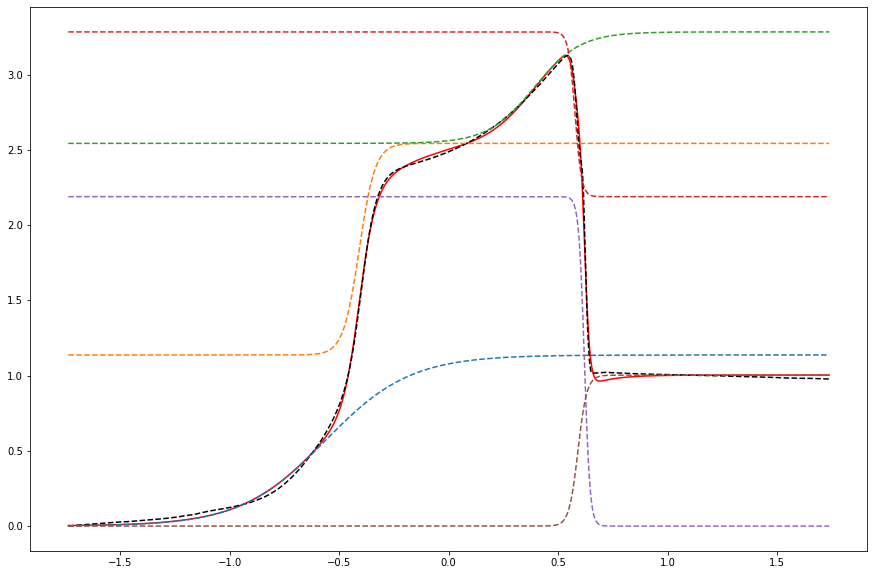

Cost = 0.0005717132559962199
Training model 3...
Epoch 00088: early stopping


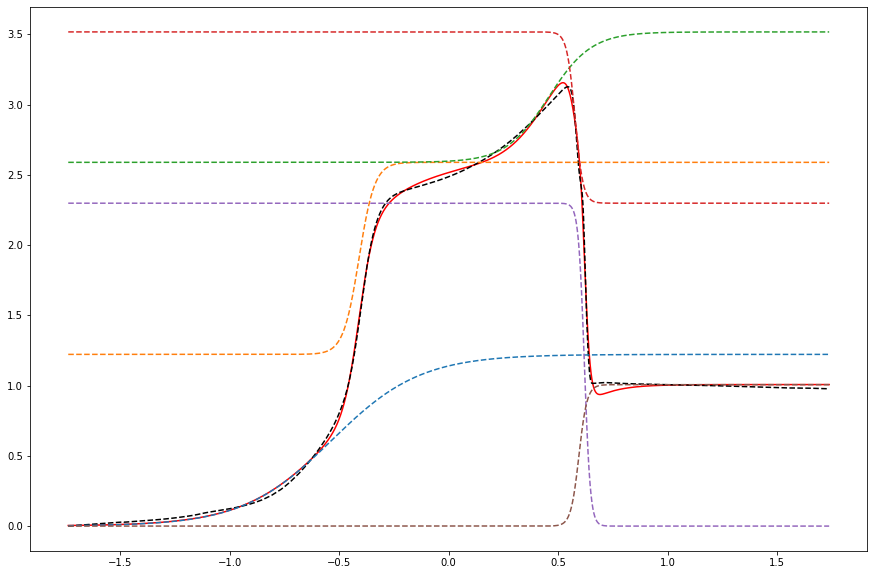

Cost = 0.0008362127314543344
Training model 4...
Epoch 00098: early stopping


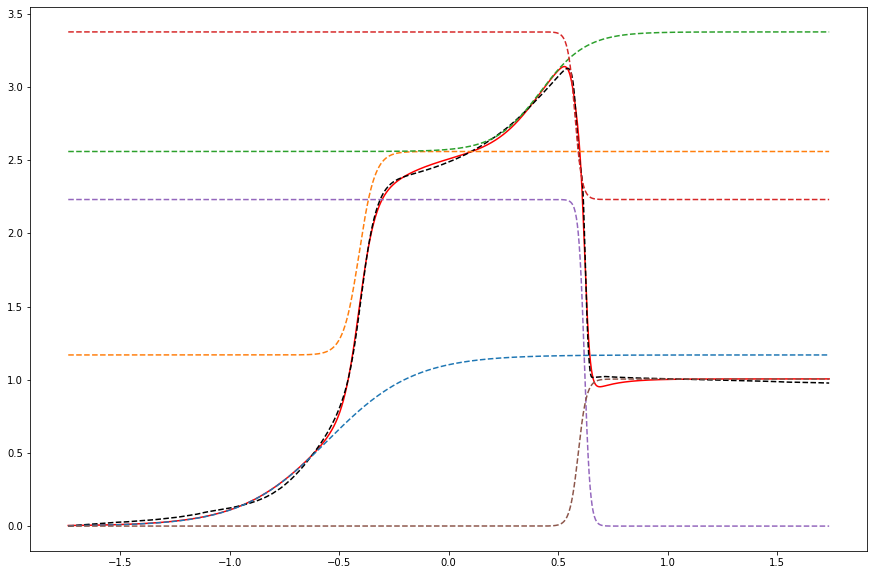

Cost = 0.0006591857283013548
Total time = 82.60949850082397


In [7]:
from time import time
t0 = time()
TrainNModels(df,hyper,lr=5e-2,epochs=500,N=5,where=where,peakRule=lambda x : 0.1 + 0.3*rand())

print(f"Total time = {time()-t0}")

### Run the following cell to let the program know which model you chose.
#### The program threw an index for each model, something like: Training model i...  In the next cell, you just have to put this i there.

In [8]:
index = input("Select a model from the produced above: ")
selectedModel = where.format(index)
finalModel = directory + 'SELECTED_INIT.hdf5'
!cp {selectedModel} {finalModel}
print(f"\nOk, model {index} will be used in the following section")

Select a model from the produced above: 2

Ok, model 2 will be used in the following section


## The following cell loads the selected model and creates a new hyper array

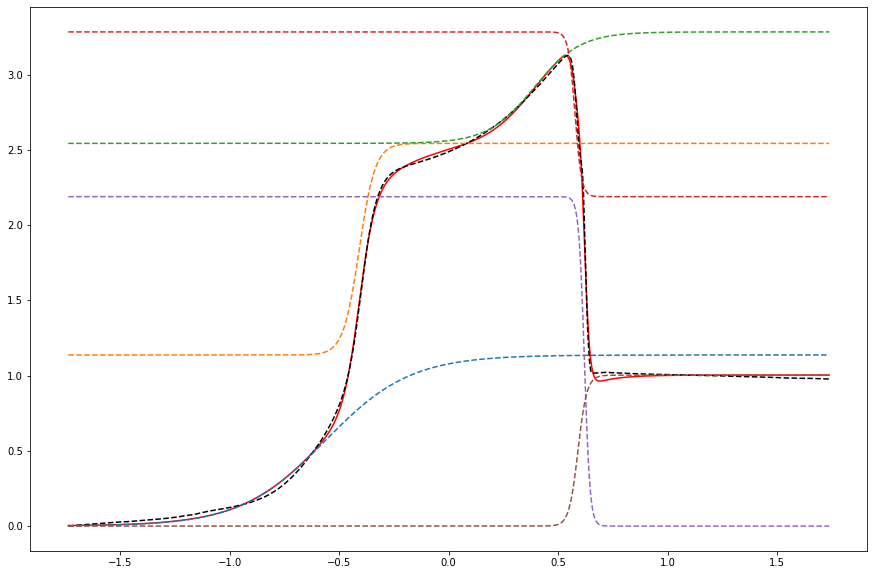

In [9]:
prms = LoadModel(finalModel,hyper)       #Load parameters from chosen model
hyper = BuildHyperFromModel(prms,hyper)  #Update the hyper array with these trained parameters
plot_wr(df,prms,hyper)                   #Plot the model once again

## 3.a. Load other data for same stoichiometry and transfer model.

In [10]:
#Load all data for La0.5
names = !ls data/*txt
names = [file for file in names if file.split('/')[1][:5] in stoichiom]

dfs = {}
for name in names:
    df,NormPrms = LoadDF(name,dom=domData)        #Load data
    DFiHyper = TransferHyper(df,hyper)    #Transfer model
    dfs[name] = (df,DFiHyper,NormPrms)
    print(f"{name} successfully loaded.")

data/La0.5Ca0.5NiO310C.txt successfully loaded.
data/La0.5Ca0.5NiO315C.txt successfully loaded.
data/La0.5Ca0.5NiO35C.txt successfully loaded.
data/La0.5Ca0.5NiO38C.txt successfully loaded.


## 3.b. Train each model.

Training for La0.5Ca0.5NiO310C.txt...
Training model 0...
Epoch 00084: early stopping


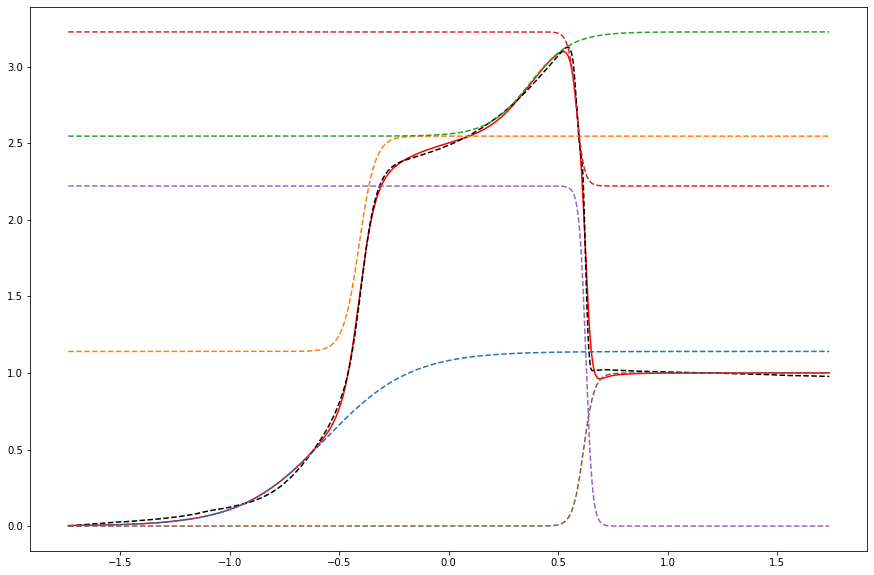

Cost = 0.0007548462664472657
Training model 1...
Epoch 00076: early stopping


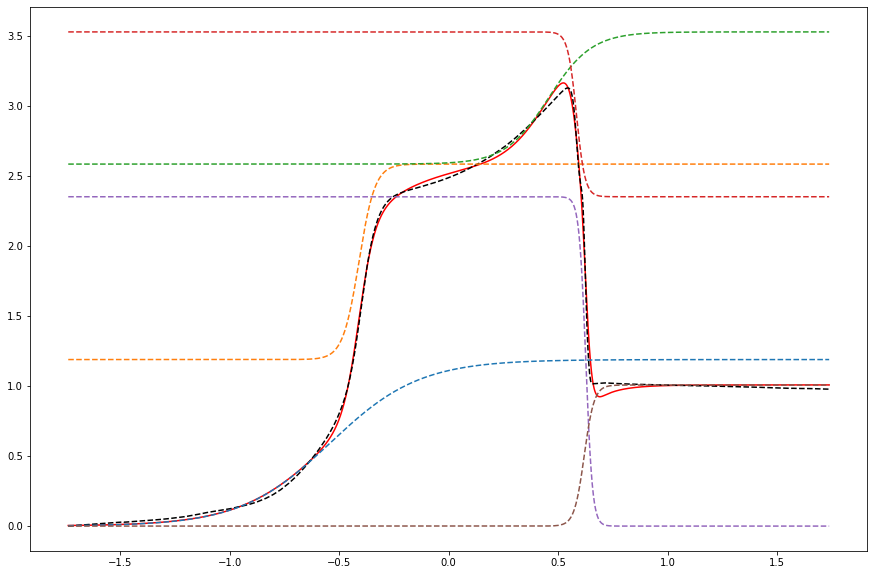

Cost = 0.0009569000286893345
Training for La0.5Ca0.5NiO315C.txt...
Training model 0...
Epoch 00073: early stopping


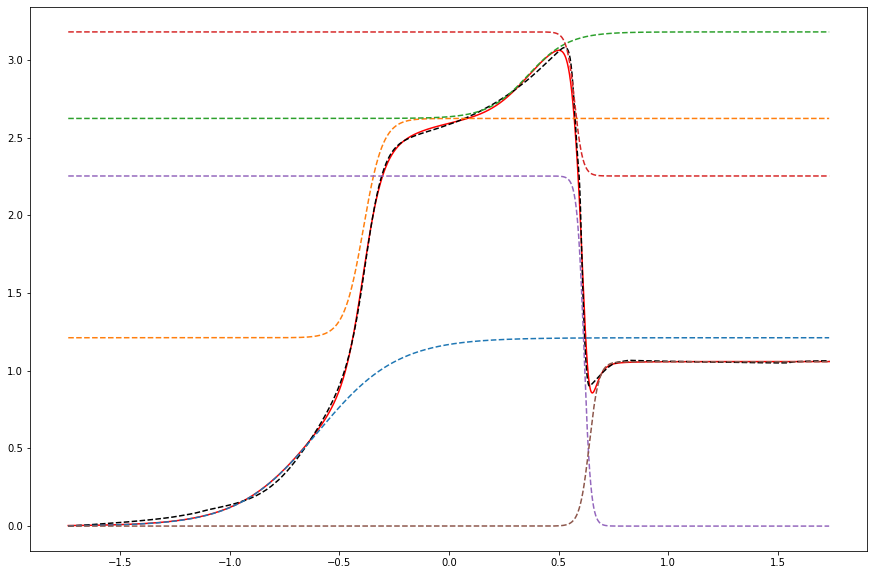

Cost = 0.0006258158257329245
Training model 1...
Epoch 00088: early stopping


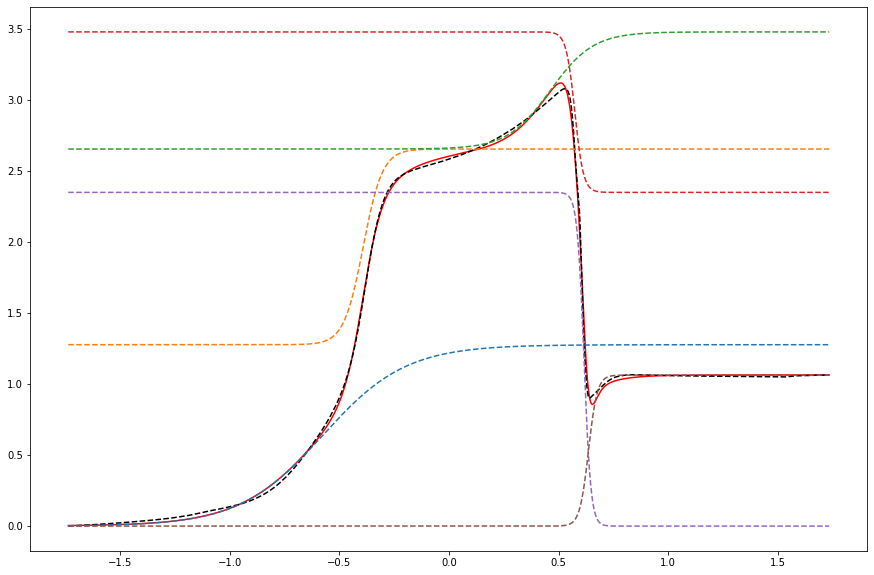

Cost = 0.0005956670440982904
Training for La0.5Ca0.5NiO35C.txt...
Training model 0...
Epoch 00068: early stopping


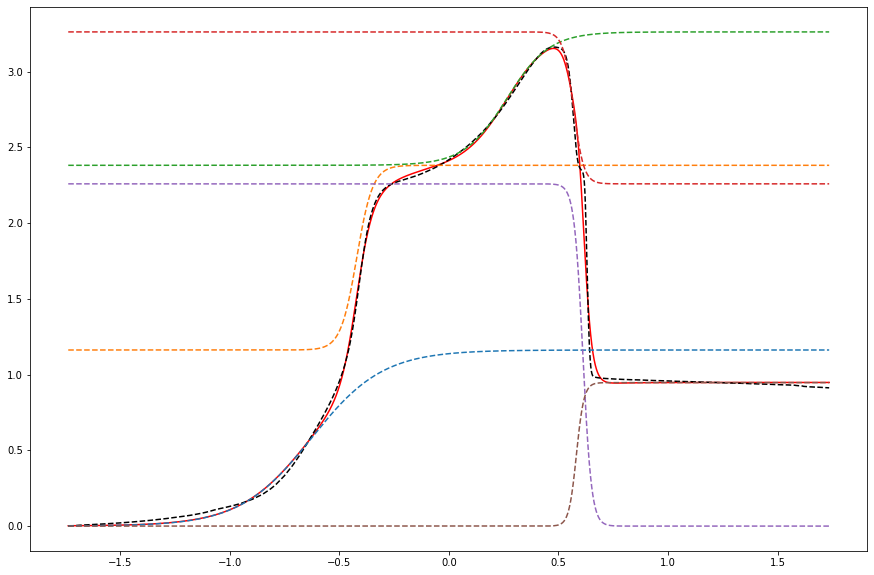

Cost = 0.001640853686253636
Training model 1...
Epoch 00078: early stopping


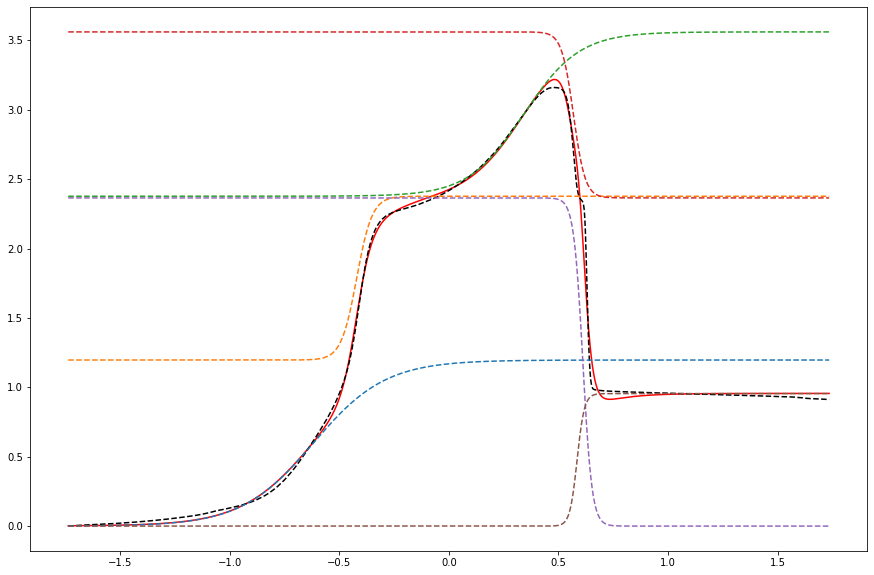

Cost = 0.0016898360654773752
Training for La0.5Ca0.5NiO38C.txt...
Training model 0...
Epoch 00078: early stopping


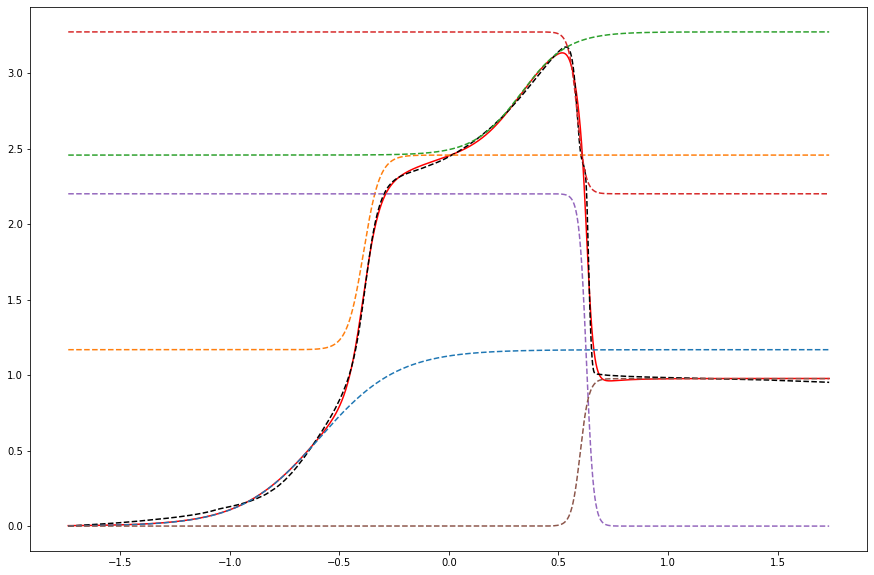

Cost = 0.0010188251739333934
Training model 1...
Epoch 00084: early stopping


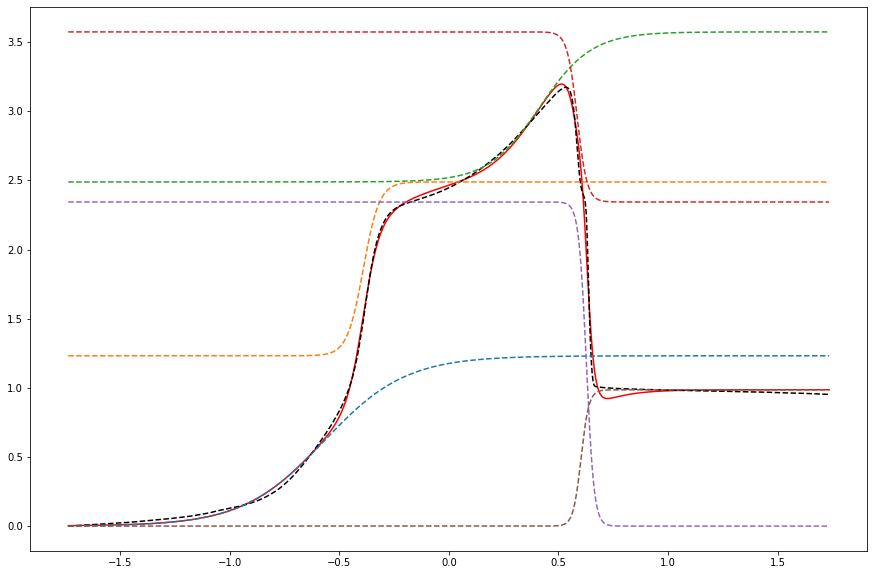

Cost = 0.0011717241058507273


In [11]:
for name in names:
    df,hyper,normPrs = dfs[name]
    name = name.split('/')[-1]
    ############## Tweak hyper to give more freedom, etc
    #Give more freedom to first and second loss, and last event.
    hyper[1,:] = 0.03  #Set range very narrow for all events
    #Unfreeze all variables
    #hyper[5,:] = 0.0 
    ############# 
    
    where = directory+name+'_W{}.hdf5'
    print(f"Training for {name}...")
    #For each DS train 2 different models with different peak heights
    TrainNModels(df,hyper,lr=1e-2,epochs=500,N=2,where=where,peakRule=lambda x: 0.1 + 0.3*x)

## 4. Now select which models out of the above trained, are to be selected.

### Similar to a few cells above, enter which models you selected.

In [12]:
for name in names:
    name = name.split('/')[-1]
    index = input(f"Select a model for {name}: ")
    where = directory+name+'_W{}.hdf5'
    selectedModel = where.format(index)
    finalModel = directory + f'SELECTED_{name}.hdf5'
    !cp {selectedModel} {finalModel}

Select a model for La0.5Ca0.5NiO310C.txt: 0
Select a model for La0.5Ca0.5NiO315C.txt: 0
Select a model for La0.5Ca0.5NiO35C.txt: 0
Select a model for La0.5Ca0.5NiO38C.txt: 0


### Now load selected models (just run this cell)

In [19]:
#Load all trained models:
PRMS = {}

for name in names:
    name = name.split('/')[-1]
    if name[:5] in stoichiom:
        file = directory + f'SELECTED_{name}.hdf5'
        print(f"Loading selected model for {name}...")
        PRMS[name] = LoadModel(file,hyper)
print("All models have been successfully loaded")

Loading selected model for La0.5Ca0.5NiO310C.txt...
Loading selected model for La0.5Ca0.5NiO315C.txt...
Loading selected model for La0.5Ca0.5NiO35C.txt...
Loading selected model for La0.5Ca0.5NiO38C.txt...
All models have been successfully loaded


## 5. Extract data and build the linear model

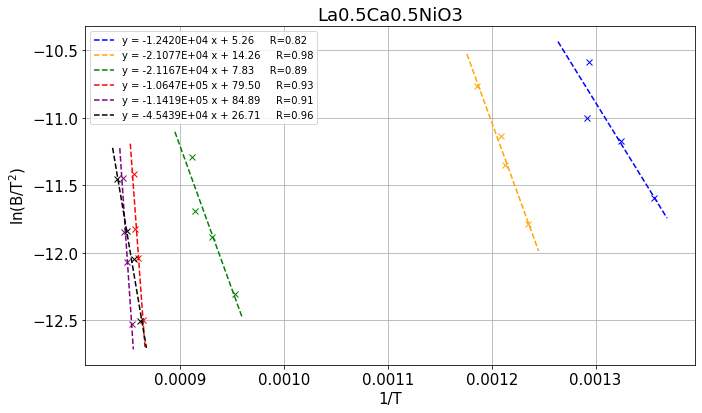

In [21]:
#Build dicts containing extracted and transformed data
#steqs = ['La0.5','La0.7']
X,Y = FeatureDict(PRMS,names,dfs,steqs=stoichiom,exponent = 2)

#All the dicts have been constructed. Now plot the data and make regression 
PlotLinearModels(X,Y,save='La0.5Arrhenius.png')